# Imports 

In [1]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [9]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200612/'
# plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200728/2018/'
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/'

os.system("mkdir -p "+ plotDir)

0

# Data Prediction Yields

In [3]:
tags = []
tags = [
    
#         'H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m',
#         'H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m',
#         'H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m',
    
        'Data 2018',
        'Data 2017',
        'Data 2016',
        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

fnames['H(bb)H(bb) 2018, 200 GeV, 1 GeV, 1 m'] = 'V1p17/v5/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['Data 2018'] = 'V1p17/v5/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018_GoodLumi.root'

fnames['H(bb)H(bb) 2017, 200 GeV, 1 GeV, 1 m'] = 'V1p17/v5/MC_Fall17/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['Data 2017'] = 'V1p17/v5/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root'

fnames['H(bb)H(bb) 2016, 200 GeV, 1 GeV, 1 m'] = 'V1p17/v4/MC_Summer16/normalized/n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
fnames['Data 2016'] = 'V1p17/v5/Data2016/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Run2016-HighMET-07Aug17_GoodLumi.root'

# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v5/Data2018/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2018_Run2018-HighMET-17Sept2018_GoodLumi.root
Open ready
Data 2018
Tree ready
<TTree b'SusyLLPTree' at 0x7f6681aad160> OrderedDict([('Data 2018', <TTree b'SusyLLPTree' at 0x7f6681aad160>)])
[[] [0.47414213 0.4274462 0.22792478] [0.51042473 0.45923573 0.47951674 ... 0.7676574 0.4250988 0.7304535] ... [0.47198224 0.4319515 0.46739426] [] [0.55735564 0.27529815 0.44638562]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1.]
/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v5/Data2017/normalized/Run2_displacedJetMuonNtupler_V1p17_Data2017_Run2017-HighMET-17Nov2017_GoodLumi.root
Open ready
Data 2017
Tree ready
<TTree b'SusyLLPTree' at 0x7f65bf771390> OrderedDict([('Data 2018', <TTree b'SusyLLPTree' at 0x7f6681aad160>), ('Data 2017', <TTree b'SusyLLPTree' at 0x7f65bf771390>)])
[[0.3825053 0.8962604] [0.2581324 0.66461104 0.44873026

In [4]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

mt_cut=100

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    mt = v['MT'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==1)
    basic_met_str = np.logical_and(basic_met_str, mt<mt_cut)
    
    if veto==1:
#         basic_met_str = np.logical_and(basic_met_str, nmu==0)
#         basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
(8328678,)


/usr/local/lib/python3.6/site-packages/awkward/array/jagged.py:1031: RuntimeWarning: invalid value encountered in greater
  result = getattr(ufunc, method)(*inputs, **kwargs)


740782
740782
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
(3438214,)
389279
389279
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>
(2390101,)
352863
352863


In [5]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
[[304.70297] [102.77982 88.73353] [464.5952] ... [160.77945 137.4149] [90.15853 57.324917] []]
[[] [] [] ... [] [] []]
[[304.70297] [102.77982 88.73353] [464.5952] ... [160.77945 137.4149] [90.15853 57.324917] []]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1]
[0 1]
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
[[91.64717 79.6208 69.474396] [220.49371 194.81148 113.98699 37.796703] [273.26236] ... [208.54443 107.37367 58.58847 41.2068] [496.3337 50.506943 34.402317] [731.131 396.2148 61.479214]]
[[] [] [] ... [] [] []]
[[91.64717 79.6208 69.474396] [220.49371 194.81148 113.98699 37.796703] [273.26236] ... [208.54443 107.37367 58.58847 41.2068] [496.3337 50.506943 34.402317] [731.131 396.2148 61.479214]]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1]
[0 1]
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>
[[794.7333] [424.42776 39.596397] [57.96184 46.701687] ... [414.60245 127.10671 37.64457] [188.05244 176.98029 167.50099] [32.464203]

In [7]:
from itertools import chain 

wall = {}
wnum = {}

#var
pt_denall = {}
pt_numall = {}

#h1s
pt_den_all = {}
pt_num_all = {}

#pEffs of h1
pt_pEff = {}


for k,v in tree.items():
    print(k,v)
    
    # denominator
    pt_denall[k] = np.array(trg_jet_pt[k].flatten())
    
    wall[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k],trg_jet_pt[k])]
    wall[k] = list(chain.from_iterable(wall[k])) 
    
    print(len(pt_denall[k]))
    print(len(wall[k]))
    
  
    #numerator
    pt_numall[k] = np.array(tag_jet_pt[k].flatten())
    
    wnum[k] = [np.array([x]*len(y)) for x,y in zip(trg_jet_w[k], tag_jet_pt[k])]
    wnum[k] = list(chain.from_iterable(wnum[k])) 
    
    
    print(len(pt_numall[k]))
    print(len(wnum[k]))
    
    #pt histogram
    pt_den_all[k] = create_TH1D( pt_denall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wall[k])
    pt_num_all[k] = create_TH1D( pt_numall[k], axis_title=['jetPt [GeV]', 'fraction of events'], name="", binning=[100,-0,1000], weights=wnum[k])

    print(pt_den_all[k].GetNbinsX())
    
    #rebin 
    x=array('d', [1,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000])
    
    pt_den_all[k]=pt_den_all[k].Rebin(len(x)-1,'',x)
    pt_num_all[k]=pt_num_all[k].Rebin(len(x)-1,'',x)
    
    print(pt_den_all[k].GetNbinsX())

    
  
    #efficiency
    pt_pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
    

Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
1142619
1142619
392
392
100
19
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
660804
660804
413
413
100
19
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>
607684
607684
541
541
100
19


Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent
Warning in <TH1D::Rebin>: Bin edge 1 of rebinned histogram does not much any bin edges of the old histogram. Result can be inconsistent


In [8]:
variables = [
    
        ['jetPt [GeV]', pt_pEff, 'pt', -0.0002, 0.002],
        
]

var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>


Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/tag_eff_jet_pt_rebin.png has been created


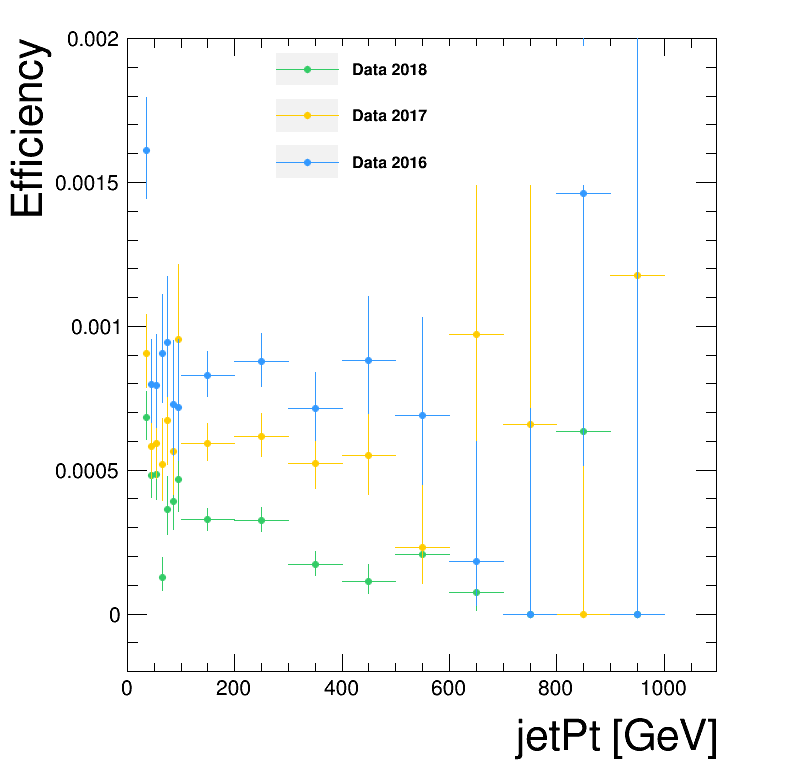

In [10]:
color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    # c.SetLogy()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


var/x_axis jetPt [GeV] name pt range -0.0002 0.002
Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200804/tag_eff_jet_pt_rebin_logX.png has been created


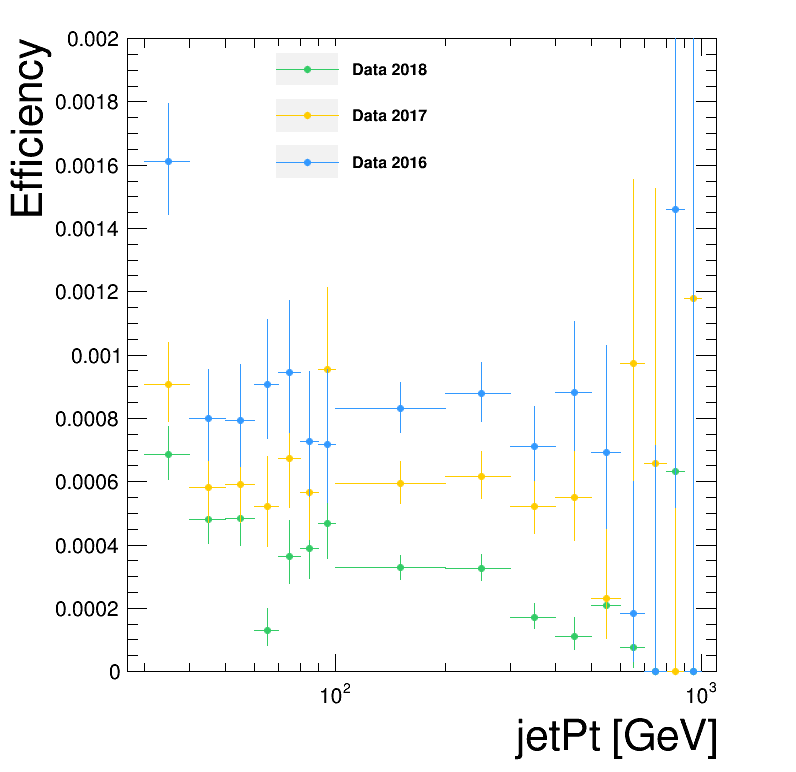

In [11]:
color_list = [845,800,861,806,1,876,597,625]

pEff = {}
for var in variables:
    print('var/x_axis', var[0], 'name', var[2], 'range',var[3],var[4])
#     outf = 'tag_eff_jet_'+var[2]+'_pt100.png'
    outf = 'tag_eff_jet_'+var[2]+'_rebin_logX.png'
#     outf = 'tag_eff_jet_'+var[2]+'.png'
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.33,0.76,0.78,0.94)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    i = 0
    for k,v in tree.items(): 
        print(k,v)


        if 'bb' not in k:
#         if 'QCD' in k:
            pEff[k] = var[1][k]
#             pEff[k] = rt.TEfficiency(eta_num_all[k], eta_den_all[k])
#             pEff[k] = rt.TEfficiency(pt_num_all[k], pt_den_all[k])
            pEff[k].SetTitle("efficiency;"+var[0]+";Efficiency")

            pEff[k].SetLineColor(color_list[i])
            pEff[k].SetMarkerColor(color_list[i])
            pEff[k].SetMarkerSize(0.8)
            pEff[k].SetMarkerStyle(20)

            if i==0:
                pEff[k].Draw("apez")
            else:
                pEff[k].Draw("pezsame")

            rt.gPad.Update()        
            #pEff[k].GetPaintedHistogram().GetXaxis().SetRangeUser(x[0],x[-1])
            pEff[k].GetPaintedGraph().SetMarkerStyle(8)
            pEff[k].GetPaintedGraph().SetMarkerSize(20)        
            pEff[k].GetPaintedGraph().SetLineColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMarkerColor(color_list[i])        
            pEff[k].GetPaintedGraph().SetMinimum(var[3])
            pEff[k].GetPaintedGraph().SetMaximum(var[4])
            pEff[k].GetPaintedGraph().GetXaxis().SetLabelSize(0.03)
            pEff[k].GetPaintedGraph().GetYaxis().SetLabelSize(0.03)


#             print('dim: ', pEff[k].GetDimension())
#             print('binN: ', pEff[k].GetPaintedGraph().GetN())
#             print('binN: ', pEff[k].GetPassedHistogram().GetNbinsX())
#             for cnt in range(len(x)):
#                 print(cnt)
#                 print('bin central x value: ', pEff[k].GetPassedHistogram().GetBinCenter(cnt))
#                 print('bin central y value: ', pEff[k].GetEfficiency(cnt))
#                 print('bin error y low: ', pEff[k].GetEfficiencyErrorLow(cnt))
#                 print('bin error y up: ', pEff[k].GetEfficiencyErrorUp(cnt))

            i += 1



            leg.AddEntry(pEff[k],k)

    leg.Draw()

    c.SetLogx()
    c.SetRightMargin(0.1)
    c.Update()
    c.Draw()
    c.SaveAs(plotDir+outf)


# Data Prediction

In [75]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==0)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

Data 2018 <TTree b'SusyLLPTree' at 0x7f1231cf2438>
(8328678,)
6444099
6444099
Data 2017 <TTree b'SusyLLPTree' at 0x7f1231ab9128>
(3438214,)
2386583
2386583
Data 2016 <TTree b'SusyLLPTree' at 0x7f11ed1d3278>
(2390101,)
1521936
1521936


In [76]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2018 <TTree b'SusyLLPTree' at 0x7f1231cf2438>
[[] [252.099 86.69548] [169.24118 72.9377 67.27325 56.723362 40.145775] ... [] [307.73352] [174.49806 162.59258]]
[[] [] [] ... [] [] []]
[[] [252.099 86.69548] [169.24118 72.9377 67.27325 56.723362 40.145775] ... [] [307.73352] [174.49806 162.59258]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[0 1 2]
[0 1 2]
Data 2017 <TTree b'SusyLLPTree' at 0x7f1231ab9128>
[[319.02103 38.096966] [435.88544 371.9999 240.39235] [273.88553 63.4606 37.26642] ... [161.09995] [446.80966] [205.14825]]
[[] [] [] ... [] [] []]
[[319.02103 38.096966] [435.88544 371.9999 240.39235] [273.88553 63.4606 37.26642] ... [161.09995] [446.80966] [205.14825]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14]
[0 1 2]
[0 1 2]
Data 2016 <TTree b'SusyLLPTree' at 0x7f11ed1d3278>
[[207.9204 44.205082] [] [] ... [] [190.4561] [50.447586 48.66071]]
[[] [] [] ... [] [] []]
[[207.9204 44.205082] [] [] ... [] [190.4561] [50.447586 48.66071]]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2]


In [77]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Bin 0 Yield', 'Bin 0 Error', 'Bin 1 Yield', 'Bin 1 Error', 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    if 'Data' not in k:
        row = [k, round (sum(trg_jet_w[k][nTags[k]==0])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==0]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==1])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==1]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==2])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==2]))*lumi*sf, 2)  ]
    else:
        row = [k, round (sum(trg_jet_w[k][nTags[k]==0])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==0]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==1])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==1]))*lumi*sf, 2) , 0.0 , 0.0  ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+
|   Sample  | Bin 0 Yield | Bin 0 Error | Bin 1 Yield | Bin 1 Error | Bin 2 Yield | Bin 2 Error |
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+
| Data 2018 |  6441108.0  |   2537.93   |    2983.0   |    54.62    |     0.0     |     0.0     |
| Data 2017 |  2384228.0  |   1544.09   |    2351.0   |    48.49    |     0.0     |     0.0     |
| Data 2016 |  1519100.0  |   1232.52   |    2825.0   |    53.15    |     0.0     |     0.0     |
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+


In [78]:
table_txt = table.get_string()
with open(plotDir+'/BeforePredictionSummaryTable.txt','w') as file:
    file.write(table_txt)

# Fake rate method

In [79]:
def GetEffWeightBin2(pts, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    evt=0
    for evt in range(len(pts)):
        cnt=0
        p2=0
        p2Up=0
        p2Low=0
        for cnt in range(len(pts[evt])):
            binN=peff.GetPassedHistogram().FindBin(pts[evt][cnt])
        
            eff1=peff.GetEfficiency(binN)
            errUp1=peff.GetEfficiencyErrorUp(binN)
            errLow1=peff.GetEfficiencyErrorLow(binN)
        
            effUp1=eff1+errUp1
            effLow1=eff1-errLow1
            
            ct=0
            for ct in range(len(pts[evt])):
                
                binN=peff.GetPassedHistogram().FindBin(pts[evt][ct])

                eff2=peff.GetEfficiency(binN)
                errUp2=peff.GetEfficiencyErrorUp(binN)
                errLow2=peff.GetEfficiencyErrorLow(binN)

                effUp2=eff2+errUp2
                effLow2=eff2-errLow2
            
                if ct>cnt:
                    p2=p2+eff1*eff2
                    p2Up=p2Up+effUp1*effUp2
                    p2Low=p2Low+effLow1*effLow2

        effW=ws[evt]*p2
        effWUp=ws[evt]*p2Up
        effWLow=ws[evt]*p2Low
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [80]:
# jet_bool = {}

cr_nj_cut = 2
cr_ntag_cut = 0

cr_jet_pt={}
cr_jet_eta={}
cr_jet_phi={}
cr_jet_w={}
cr_jet_pts={}
cr_jet_etas={}
cr_jet_phis={}
cr_jet_ws={}

pt_pred_jet_ws={}
pt_pred_jet_ws_up={}
pt_pred_jet_ws_low={}

eta_pred_jet_ws={}
eta_pred_jet_ws_up={}
eta_pred_jet_ws_low={}

phi_pred_jet_ws={}
phi_pred_jet_ws_up={}
phi_pred_jet_ws_low={}

pt_eta_pred_jet_ws={}
pt_eta_pred_jet_ws_up={}
pt_eta_pred_jet_ws_low={}

pt_phi_pred_jet_ws={}
pt_phi_pred_jet_ws_up={}
pt_phi_pred_jet_ws_low={}

for k,v in tree.items():
    print(k,v)
            
#     jet_bool[k] = tagged_jet
    
#     print(jet_bool[k][:10])
    
    cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
    
    cr_jet_pt[k] = trg_jet_pt[k][cr_cut_str]
    cr_jet_eta[k] = trg_jet_eta[k][cr_cut_str]
    cr_jet_phi[k] = trg_jet_phi[k][cr_cut_str]
    cr_jet_w[k] = trg_jet_w[k][cr_cut_str]
    
    # to bin1
    cr_jet_pts[k] = cr_jet_pt[k].flatten()
    cr_jet_etas[k] = cr_jet_eta[k].flatten()
    cr_jet_phis[k] = cr_jet_phi[k].flatten()
    cr_jet_ws[k] = [np.array([x]*len(y)) for x,y in zip(cr_jet_w[k],cr_jet_pt[k])]
    cr_jet_ws[k] = list(chain.from_iterable(cr_jet_ws[k])) 
    
    print(len(cr_jet_pt[k]))
    print(len(cr_jet_w[k]))
    
    print(len(cr_jet_pts[k]))
    print(len(cr_jet_ws[k]))
    
    #1d 
    # to bin2
    pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeightBin2(cr_jet_pt[k], cr_jet_w[k], pt_pEff[k])
    
    
    print(len(pt_pred_jet_ws[k]))
    
 
    

Data 2018 <TTree b'SusyLLPTree' at 0x7f1231cf2438>
1894502
1894502
4823466
4823466
1894502
Data 2017 <TTree b'SusyLLPTree' at 0x7f1231ab9128>
837230
837230
2228153
2228153
837230
Data 2016 <TTree b'SusyLLPTree' at 0x7f11ed1d3278>
674365
674365
1798377
1798377
674365


In [81]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'method', 'Bin 2 Prediction', 'Bin 2 Prediction Error' ,'Bin 2 Prediction Error Up', 'Bin 2 Prediction Error Low'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    ErrUp = abs(sum(pt_pred_jet_ws_up[k])-sum(pt_pred_jet_ws[k]))*lumi*sf
    ErrLow = abs(sum(pt_pred_jet_ws_low[k])-sum(pt_pred_jet_ws[k]))*lumi*sf
    Err = 0.5*abs(ErrUp+ErrLow)
    row = [k, '1D pt', round (sum(pt_pred_jet_ws[k])*lumi*sf, 2) , round ( Err , 2) , round (ErrUp  , 2) , round (ErrLow  , 2)]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 2 Prediction | Bin 2 Prediction Error | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
| Data 2018 | 1D pt  |       0.58       |          0.26          |            0.35           |            0.18            |
| Data 2017 | 1D pt  |       0.88       |          0.45          |            0.61           |            0.29            |
| Data 2016 | 1D pt  |       1.47       |          0.58          |            0.74           |            0.41            |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+


In [82]:
table_txt = table.get_string()
with open(plotDir+'/PredictionSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)

# 1photon prediction

In [12]:
trg_path=310
njet_cut=-1
met_cut=200
mdphi_cut=0.5
veto=1

# jet_eta_cut=2.4
jet_eta_cut=1.48
jet_pt_cut=30
jet_time_cut=-1
jet_phoef_cut=0.8
jet_muef_cut=0.6
jet_eleef_cut=0.6


trg_jet_met = {}
trg_jet_nj = {}
trg_jet_mt = {}
trg_jet_ht = {}
trg_jet_mdphi = {}
trg_jet_w = {} 

trg_jet_pt = {}
trg_jet_eta = {}
trg_jet_e = {}
trg_jet_phi = {}

trg_jet_chef = {}
trg_jet_muef = {}
trg_jet_eleef = {}
trg_jet_phoef = {}

trg_jet_nhef = {}
trg_jet_cemef = {}
trg_jet_nemef = {}

trg_jet_tmf = {}
trg_jet_dr = {}
trg_jet_time = {}


for k,v in tree.items():
    print(k,v)

    # branches
    met = v['met'].array()
#     mt = v['MT_'].array()
    ht = v['HT'].array()
#     mdphi = v['jetMet_dPhi'].array()
    mdphi = v['jetMet_dPhiMin'].array()
    hlt = v['HLTDecision'].array()[:,trg_path]
    nj = v['nJets'].array()
    nlep = v['nLeptons'].array()
    nmu = v['nMuons'].array()
    nele = v['nElectrons'].array()
    ntau = v['nTaus'].array()
    npho = v['nPhotons'].array()
    
    #flags
    flag1 =  v['Flag2_globalSuperTightHalo2016Filter'].array()
#     flag2 =  v['Flag2_globalTightHalo2016Filter'].array() 
#     flag3 =  v['Flag2_goodVertices'].array()
#     flag4 =  v['Flag2_BadChargedCandidateFilter'].array() 
    flag5 =  v['Flag2_BadPFMuonFilter'].array() 
    flag6 =  v['Flag2_EcalDeadCellTriggerPrimitiveFilter'].array() 
    flag7 =  v['Flag2_HBHENoiseFilter'].array() 
    flag8 =  v['Flag2_HBHEIsoNoiseFilter'].array() 
    flag9 =  v['Flag2_ecalBadCalibFilter'].array() 
    flag10 =  v['Flag2_eeBadScFilter'].array() 
    
    #jet var
    pt = v['jetPt'].array()
    eta = v['jetEta'].array()
    e = v['jetE'].array()
    phi = v['jetPhi'].array()
    
    chef = v['jetChargedHadronEnergyFraction'].array()
    muef = v['jetMuonEnergyFraction'].array()
    eleef = v['jetElectronEnergyFraction'].array()
    phoef = v['jetPhotonEnergyFraction'].array()
    
#     nhef = v['jetNeutralHadronEnergyFraction'].array()
#     cemef = v['jetNeutralEMEnergyFraction'].array()
#     nemef = v['jetNeutralEMEnergyFraction'].array()
 
    tmf = v['jetGammaMax_ET'].array()
    dr = v['jetMinDeltaRPVTracks'].array()
    time = v['jetTime'].array()

    weight = v['weight'].array()
    
    print(weight.shape)
    
    #selection
    
    sel_hlt_triggered = 1
    sel_hlt_str  = np.logical_and(sel_hlt_triggered, hlt)
    
    sel_flag_str = np.logical_and(flag1, flag5)
    sel_flag_str = np.logical_and(sel_flag_str, flag6)
    sel_flag_str = np.logical_and(sel_flag_str, flag7)
    sel_flag_str = np.logical_and(sel_flag_str, flag8)
    if '2016' not in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag9)
    if 'Data' in k:
        sel_flag_str = np.logical_and(sel_flag_str, flag10)

    basic_met_str = np.logical_and(nj>njet_cut, met>met_cut)    
    basic_met_str = np.logical_and(basic_met_str, pt.count()>njet_cut)
    basic_met_str = np.logical_and(basic_met_str, nlep==0)
    
    if veto==1:
        basic_met_str = np.logical_and(basic_met_str, nmu==0)
        basic_met_str = np.logical_and(basic_met_str, nele==0)
        basic_met_str = np.logical_and(basic_met_str, ntau==0)
        basic_met_str = np.logical_and(basic_met_str, npho==1)
    
    basic_jet_str = np.logical_and(abs(eta)<jet_eta_cut, pt>jet_pt_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, time>jet_time_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, phoef<jet_phoef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, muef<jet_muef_cut)   
    basic_jet_str = np.logical_and(basic_jet_str, eleef<jet_eleef_cut)   

    met_trg_str = np.logical_and(basic_met_str, sel_hlt_str)
    met_trg_str = np.logical_and(basic_met_str, sel_flag_str)
#     met_trg_str = np.logical_and(basic_met_str, mdphi>mdphi_cut)
#     met_trg_str = np.logical_and(basic_met_str, mdphi<=mdphi_cut)
    
#   sel 
#     trg_jet_met[k] = met
#     trg_jet_nj[k] = nj 
#     trg_jet_w[k] = weight 
# #     trg_jet_mt[k] = mt
#     trg_jet_ht[k] = ht
#     trg_jet_mdphi[k] = mdphi
    
#     trg_jet_pt[k] = pt
#     trg_jet_eta[k] = eta
#     trg_jet_e[k] = e
#     trg_jet_phi[k] = phi
#     trg_jet_chef[k] = chef
#     trg_jet_nhef[k] = nhef
#     trg_jet_cemef[k] = cemef
#     trg_jet_nemef[k] = nemef
    
    #apply sel
    trg_jet_met[k] = met[met_trg_str]
    trg_jet_ht[k] = ht[met_trg_str]
    trg_jet_mdphi[k] = mdphi[met_trg_str]
    trg_jet_nj[k] = nj[met_trg_str]
    trg_jet_w[k] = weight[met_trg_str]

    trg_jet_pt[k] = pt[basic_jet_str][met_trg_str]
    trg_jet_phi[k] = phi[basic_jet_str][met_trg_str]
    trg_jet_eta[k] = eta[basic_jet_str][met_trg_str]
    trg_jet_e[k] = e[basic_jet_str][met_trg_str]

#     trg_jet_nhm[k] = nhm[basic_jet_str][met_trg_str]
#     trg_jet_chm[k] = chm[basic_jet_str][met_trg_str]
#     trg_jet_mum[k] = mum[basic_jet_str][met_trg_str]
#     trg_jet_elem[k] = elem[basic_jet_str][met_trg_str]
#     trg_jet_phom[k] = phom[basic_jet_str][met_trg_str]
    
#     trg_jet_nhef[k] = nhef[basic_jet_str][met_trg_str]
    trg_jet_chef[k] = chef[basic_jet_str][met_trg_str]
    trg_jet_muef[k] = muef[basic_jet_str][met_trg_str]
    trg_jet_eleef[k] = eleef[basic_jet_str][met_trg_str]
    trg_jet_phoef[k] = phoef[basic_jet_str][met_trg_str]
    
#     trg_jet_csv[k] = csv[basic_jet_str][met_trg_str]
    
#     trg_jet_nrec[k] = nrec[basic_jet_str][met_trg_str]
    trg_jet_time[k] = time[basic_jet_str][met_trg_str]
    trg_jet_dr[k] = dr[basic_jet_str][met_trg_str]
    trg_jet_tmf[k] = tmf[basic_jet_str][met_trg_str]
#     trg_jet_amax[k] = amax[basic_jet_str][met_trg_str]

    #clean up
    trg_jet_met[k] = trg_jet_met[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_ht[k] = trg_jet_ht[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_mdphi[k] = trg_jet_mdphi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_nj[k] = trg_jet_nj[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_w[k] = trg_jet_w[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_phi[k] = trg_jet_phi[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eta[k] = trg_jet_eta[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_e[k] = trg_jet_e[k][trg_jet_pt[k].count()>njet_cut]

#     trg_jet_nhm[k] = trg_jet_nhm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_chm[k] = trg_jet_chm[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_mum[k] = trg_jet_mum[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_elem[k] = trg_jet_elem[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_phom[k] = trg_jet_phom[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nhef[k] = trg_jet_nhef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_chef[k] = trg_jet_chef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_muef[k] = trg_jet_muef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_eleef[k] = trg_jet_eleef[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_phoef[k] = trg_jet_phoef[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_csv[k] = trg_jet_csv[k][trg_jet_pt[k].count()>njet_cut]
    
#     trg_jet_nrec[k] = trg_jet_nrec[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_time[k] = trg_jet_time[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_dr[k] = trg_jet_dr[k][trg_jet_pt[k].count()>njet_cut]
    trg_jet_tmf[k] = trg_jet_tmf[k][trg_jet_pt[k].count()>njet_cut]
#     trg_jet_amax[k] = trg_jet_amax[k][trg_jet_pt[k].count()>njet_cut]

    trg_jet_pt[k] = trg_jet_pt[k][trg_jet_pt[k].count()>njet_cut]

    #print out check


    print(len(trg_jet_w[k]))
    print(len(trg_jet_pt[k]))

    

Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
(8328678,)
83246
83246
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
(3438214,)
40684
40684
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>
(2390101,)
48153
48153


In [13]:
# time_cut = 0.08676443430239597
# tmf_cut = 0.16335152541277656 
# dr_cut = 0.06402562462487048
# chef_cut = 0.061590940809278155

time_cut = 0.09
tmf_cut = 0.16 
dr_cut = 0.06 
chef_cut = 0.06 

nTags = {}
nJets = {}

tag_jet_pt = {}
tag_jet_eta = {}
tag_jet_phi = {}
tag_jet_e = {}

tag_jet_chef = {}
tag_jet_tmf = {}
tag_jet_time = {}
tag_jet_dr = {}

tag_jet_phoef = {}
tag_jet_eleef = {}
tag_jet_muef = {}

untag_jet_pt = {}
untag_jet_eta = {}
untag_jet_phi = {}
untag_jet_e = {}

untag_jet_chef = {}
untag_jet_tmf = {}
untag_jet_time = {}
untag_jet_dr = {}

untag_jet_phoef = {}
untag_jet_eleef = {}
untag_jet_muef = {}

for k,v in tree.items():
    print(k,v)
    
    nJets[k] = trg_jet_pt[k].count()
    
    #tag cuts
    tagged_jet = np.logical_and(trg_jet_tmf[k]<tmf_cut, trg_jet_dr[k]>dr_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_time[k]>time_cut)
    tagged_jet = np.logical_and(tagged_jet, trg_jet_chef[k]<chef_cut) 
    
    untagged_jet = np.logical_not(tagged_jet) 
    
    nTags[k] = trg_jet_pt[k][tagged_jet].count()
    
    tag_jet_pt[k] = trg_jet_pt[k][tagged_jet] 
    tag_jet_eta[k] = trg_jet_eta[k][tagged_jet] 
    tag_jet_e[k] = trg_jet_e[k][tagged_jet] 
    tag_jet_phi[k] = trg_jet_phi[k][tagged_jet]
    
    tag_jet_chef[k] = trg_jet_chef[k][tagged_jet] 
    tag_jet_tmf[k] = trg_jet_tmf[k][tagged_jet] 
    tag_jet_time[k] = trg_jet_time[k][tagged_jet] 
    tag_jet_dr[k] = trg_jet_dr[k][tagged_jet] 
    
    tag_jet_phoef[k] = trg_jet_phoef[k][tagged_jet] 
    tag_jet_muef[k] = trg_jet_muef[k][tagged_jet] 
    tag_jet_eleef[k] = trg_jet_eleef[k][tagged_jet] 
    
    untag_jet_pt[k] = trg_jet_pt[k][untagged_jet] 
    untag_jet_eta[k] = trg_jet_eta[k][untagged_jet] 
    untag_jet_e[k] = trg_jet_e[k][untagged_jet] 
    untag_jet_phi[k] = trg_jet_phi[k][untagged_jet]
    
    untag_jet_chef[k] = trg_jet_chef[k][untagged_jet] 
    untag_jet_tmf[k] = trg_jet_tmf[k][untagged_jet] 
    untag_jet_time[k] = trg_jet_time[k][untagged_jet] 
    untag_jet_dr[k] = trg_jet_dr[k][untagged_jet] 
    
    untag_jet_phoef[k] = trg_jet_phoef[k][untagged_jet] 
    untag_jet_muef[k] = trg_jet_muef[k][untagged_jet] 
    untag_jet_eleef[k] = trg_jet_eleef[k][untagged_jet] 
    
    print(trg_jet_pt[k][:10])
    print(tag_jet_pt[k][:10])
    print(untag_jet_pt[k][:10])
    
    print(np.unique(nJets[k]))
    print(np.unique(nTags[k]))
    
    for i,ele in enumerate(nTags[k]):
        if ele > 2:
            nTags[k][i] = 2
            
    print(np.unique(nTags[k]))
    

Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
[[651.3212 388.2027 72.47353] [261.73285 59.447098 39.15245 33.21327] [] ... [154.6416 41.657276 37.632877] [] []]
[[] [] [] ... [] [] []]
[[651.3212 388.2027 72.47353] [261.73285 59.447098 39.15245 33.21327] [] ... [154.6416 41.657276 37.632877] [] []]
[0 1 2 3 4 5 6 7 8 9]
[0 1]
[0 1]
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
[[530.0356 106.93811] [] [116.29011 58.18837] ... [] [279.8735 278.5679] [45.3211]]
[[] [] [] ... [] [] []]
[[530.0356 106.93811] [] [116.29011 58.18837] ... [] [279.8735 278.5679] [45.3211]]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1]
[0 1]
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>
[[191.92502 57.163082 33.574776] [] [306.73987] ... [175.52805] [196.85176 70.85701 48.62091 32.864292] []]
[[] [] [] ... [] [] []]
[[191.92502 57.163082 33.574776] [] [306.73987] ... [175.52805] [196.85176 70.85701 48.62091 32.864292] []]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1]
[0 1]


In [14]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'Bin 0 Yield', 'Bin 0 Error', 'Bin 1 Yield', 'Bin 1 Error', 'Bin 2 Yield', 'Bin 2 Error'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    if 'Data' not in k:
        row = [k, round (sum(trg_jet_w[k][nTags[k]==0])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==0]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==1])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==1]))*lumi*sf, 2) , round (sum(trg_jet_w[k][nTags[k]==2])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==2]))*lumi*sf, 2)  ]
    else:
        row = [k, round (sum(trg_jet_w[k][nTags[k]==0])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==0]))*lumi*sf, 2) , 
               round (sum(trg_jet_w[k][nTags[k]==1])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==1]))*lumi*sf, 2) ,
               round (sum(trg_jet_w[k][nTags[k]==2])*lumi*sf, 2) , round (math.sqrt(sum(x*x for x in trg_jet_w[k][nTags[k]==2]))*lumi*sf, 2) 
#                0.0 , 0.0  
              ]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+
|   Sample  | Bin 0 Yield | Bin 0 Error | Bin 1 Yield | Bin 1 Error | Bin 2 Yield | Bin 2 Error |
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+
| Data 2018 |   83208.0   |    288.46   |     38.0    |     6.16    |      0      |     0.0     |
| Data 2017 |   40651.0   |    201.62   |     33.0    |     5.74    |      0      |     0.0     |
| Data 2016 |   48103.0   |    219.32   |     50.0    |     7.07    |      0      |     0.0     |
+-----------+-------------+-------------+-------------+-------------+-------------+-------------+


In [15]:
table_txt = table.get_string()
with open(plotDir+'/PHO_BeforePredictionSummaryTable.txt','w') as file:
    file.write(table_txt)

# Fake rate method

In [16]:
def GetEffWeightBin2(pts, ws, peff):
    EffW=[]
    EffWUp=[]
    EffWLow=[]
    evt=0
    for evt in range(len(pts)):
        cnt=0
        p2=0
        p2Up=0
        p2Low=0
        for cnt in range(len(pts[evt])):
            binN=peff.GetPassedHistogram().FindBin(pts[evt][cnt])
        
            eff1=peff.GetEfficiency(binN)
            errUp1=peff.GetEfficiencyErrorUp(binN)
            errLow1=peff.GetEfficiencyErrorLow(binN)
        
            effUp1=eff1+errUp1
            effLow1=eff1-errLow1
            
            ct=0
            for ct in range(len(pts[evt])):
                
                binN=peff.GetPassedHistogram().FindBin(pts[evt][ct])

                eff2=peff.GetEfficiency(binN)
                errUp2=peff.GetEfficiencyErrorUp(binN)
                errLow2=peff.GetEfficiencyErrorLow(binN)

                effUp2=eff2+errUp2
                effLow2=eff2-errLow2
            
                if ct>cnt:
                    p2=p2+eff1*eff2
                    p2Up=p2Up+effUp1*effUp2
                    p2Low=p2Low+effLow1*effLow2

        effW=ws[evt]*p2
        effWUp=ws[evt]*p2Up
        effWLow=ws[evt]*p2Low
        
        EffW.append(effW)
        EffWUp.append(effWUp)
        EffWLow.append(effWLow)
        
    return EffW, EffWUp, EffWLow
        
        

In [17]:
# jet_bool = {}

cr_nj_cut = 2
cr_ntag_cut = 0

cr_jet_pt={}
cr_jet_eta={}
cr_jet_phi={}
cr_jet_w={}
cr_jet_pts={}
cr_jet_etas={}
cr_jet_phis={}
cr_jet_ws={}

pt_pred_jet_ws={}
pt_pred_jet_ws_up={}
pt_pred_jet_ws_low={}

eta_pred_jet_ws={}
eta_pred_jet_ws_up={}
eta_pred_jet_ws_low={}

phi_pred_jet_ws={}
phi_pred_jet_ws_up={}
phi_pred_jet_ws_low={}

pt_eta_pred_jet_ws={}
pt_eta_pred_jet_ws_up={}
pt_eta_pred_jet_ws_low={}

pt_phi_pred_jet_ws={}
pt_phi_pred_jet_ws_up={}
pt_phi_pred_jet_ws_low={}

for k,v in tree.items():
    print(k,v)
            
#     jet_bool[k] = tagged_jet
    
#     print(jet_bool[k][:10])
    
    cr_cut_str=np.logical_and(nJets[k]>=cr_nj_cut, nTags[k]==cr_ntag_cut)
    
    cr_jet_pt[k] = trg_jet_pt[k][cr_cut_str]
    cr_jet_eta[k] = trg_jet_eta[k][cr_cut_str]
    cr_jet_phi[k] = trg_jet_phi[k][cr_cut_str]
    cr_jet_w[k] = trg_jet_w[k][cr_cut_str]
    
    # to bin1
    cr_jet_pts[k] = cr_jet_pt[k].flatten()
    cr_jet_etas[k] = cr_jet_eta[k].flatten()
    cr_jet_phis[k] = cr_jet_phi[k].flatten()
    cr_jet_ws[k] = [np.array([x]*len(y)) for x,y in zip(cr_jet_w[k],cr_jet_pt[k])]
    cr_jet_ws[k] = list(chain.from_iterable(cr_jet_ws[k])) 
    
    print(len(cr_jet_pt[k]))
    print(len(cr_jet_w[k]))
    
    print(len(cr_jet_pts[k]))
    print(len(cr_jet_ws[k]))
    
    #1d 
    # to bin2
    pt_pred_jet_ws[k], pt_pred_jet_ws_up[k], pt_pred_jet_ws_low[k]  = GetEffWeightBin2(cr_jet_pt[k], cr_jet_w[k], pt_pEff[k])
    
    
    print(len(pt_pred_jet_ws[k]))
    
 
    

Data 2018 <TTree b'SusyLLPTree' at 0x7f6681aad160>
23971
23971
62779
62779
23971
Data 2017 <TTree b'SusyLLPTree' at 0x7f65bf771390>
13783
13783
37315
37315
13783
Data 2016 <TTree b'SusyLLPTree' at 0x7f65b74cd0b8>
12897
12897
34857
34857
12897


In [18]:
from prettytable import PrettyTable
print('\n\n======================= Summary ==============================')
table =  PrettyTable(['Sample', 'method', 'Bin 2 Prediction', 'Bin 2 Prediction Error' ,'Bin 2 Prediction Error Up', 'Bin 2 Prediction Error Low'])
for k,v in tree.items():
    if 'Data' in k:
        lumi=1
        sf=1
    ErrUp = abs(sum(pt_pred_jet_ws_up[k])-sum(pt_pred_jet_ws[k]))*lumi*sf
    ErrLow = abs(sum(pt_pred_jet_ws_low[k])-sum(pt_pred_jet_ws[k]))*lumi*sf
    Err = 0.5*abs(ErrUp+ErrLow)
    row = [k, '1D pt', round (sum(pt_pred_jet_ws[k])*lumi*sf, 2) , round ( Err , 2) , round (ErrUp  , 2) , round (ErrLow  , 2)]
    table.add_row(row)
        
print(table)



======================= Summary ==============================
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
|   Sample  | method | Bin 2 Prediction | Bin 2 Prediction Error | Bin 2 Prediction Error Up | Bin 2 Prediction Error Low |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+
| Data 2018 | 1D pt  |       0.01       |          0.0           |            0.0            |            0.0             |
| Data 2017 | 1D pt  |       0.02       |          0.01          |            0.01           |            0.0             |
| Data 2016 | 1D pt  |       0.03       |          0.01          |            0.01           |            0.01            |
+-----------+--------+------------------+------------------------+---------------------------+----------------------------+


In [82]:
table_txt = table.get_string()
with open(plotDir+'/PHO_PredictionSummaryTableBin2Rebin.txt','w') as file:
    file.write(table_txt)